In [1]:
!git clone https://github.com/openai/CLIP.git
# CLIP (Contrastive Language Image Pre-Training)
# Learning Transferable Models From Natural Language Supervision
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 256 (delta 126), reused 110 (delta 110), pack-reused 102 (from 1)
Receiving objects: 100% (256/256), 8.86 MiB | 34.91 MiB/s, done.
Resolving deltas: 100% (140/140), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 46.60 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [2]:
### load some extra libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip install torchmetrics==0.3.2 --quiet
!pip uninstall torchtext --yes
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 7.7 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: omegaconf
    Found existing installation: omegaconf 2.3.0
    Uninstalling omegaconf-2.3.0:
      Successfully uninstalled omegaconf-2.3.0
  Attempting uninstall: nvidia-nvjitl

In [3]:
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch import nn

import PIL
import matplotlib.pyplot as plt

import yaml
from omegaconf import OmegaConf

from CLIP import clip

In [4]:
##helper functions

def show_from_tensor(tensor):

  img = tensor.clone()
  img = img.mul(255).byte() # because img values are in [0,1]
  img = img.cpu().numpy().transpose((1,2,0)) # channel, with, height?

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt,plt.show()

  return

def norm_data(data):
  return (data.clip(-1,1) + 1) / 2 ##any range between 0 and 1 is the result


###Parameters
learning_rate = 0.5
batch_size = 1
wd = 0.1
noise_factor = 0.1

total_iter = 400
im_shape = [255, 400, 3] #height, width, channels
size1, size2, channels = im_shape

In [5]:
### CLIP MODEL ###
clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution", clipmodel.visual.input_resolution)

device = torch.device("cuda:0")
torch.cuda.empty_cache()

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 143MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution 224


In [6]:
###Transformer instantiation

%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'

/kaggle/working/taming-transformers
--2025-06-25 06:52:22--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/e0b6d3f2-5215-4e39-9af9-bb955bc42fe3/last.ckpt [following]
--2025-06-25 06:52:23--  https://heibox.uni-heidelberg.de/seafhttp/files/e0b6d3f2-5215-4e39-9af9-bb955bc42fe3/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  12.5MB/s    in 80s     

2025-06-25 06:53:43 (11.7 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092

In [7]:
!sed -i 's/from torch._six import string_classes/string_classes = str/g' /kaggle/working/taming-transformers/taming/data/utils.py

In [8]:
from taming.models.vqgan import VQModel
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

def load_config(config_path, display=False):
  config_data = OmegaConf.load(config_path)

  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))

  return config_data

def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    torch.serialization.add_safe_globals([ModelCheckpoint]) # if anything breaks remove this and the second line of the cell
    state_dict = torch.load(chk_path, map_location="cpu", weights_only=False)["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()

def generator(X):
  X = taming_model.post_quant_conv(X)
  X = taming_model.decoder(X)

  return X

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)

2025-06-25 06:53:46.885497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750834427.070410      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750834427.120657      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 196MB/s] 


8.19kB [00:00, 594kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [9]:
###Values i am going to optimize

class Parameters(nn.Module):
    def __init__(self):
        super(Parameters, self).__init__()
        self.data = 0.5 * torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1x256x14x25 (256/16, 400/16)
        self.data = nn.Parameter(torch.sin(self.data))


    def forward(self):
        return self.data

def init_params():
    params = Parameters().cuda()
    optimizer = torch.optim.AdamW([{'params': [params.data], 'lr': learning_rate}], weight_decay=wd)
    return params, optimizer

torch.Size([1, 256, 15, 25])
img dimensions torch.Size([1, 3, 240, 400])


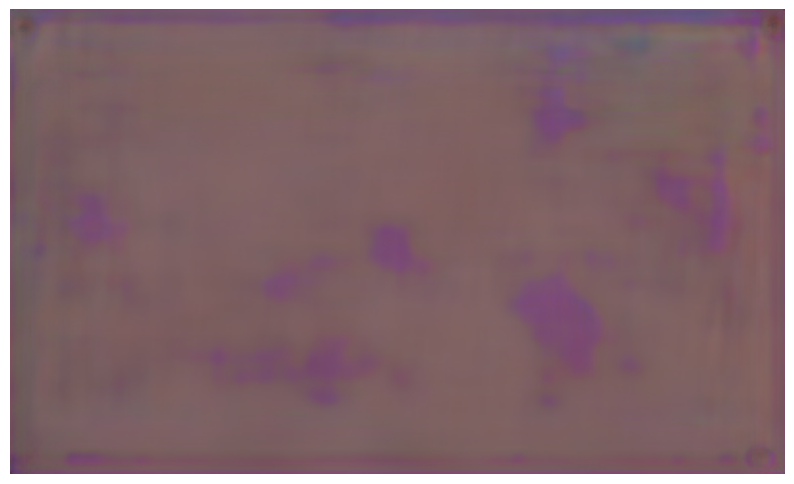

In [10]:
###Encoding prompts and a few more things
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encode_text(text):
    t = clip.tokenize(text).cuda()
    t = clipmodel.encode_text(t).detach().clone()
    return t

def createEncodings(include, exclude, extras):
    include_enc = []
    for text in include:
        include_enc.append(encode_text(text))

    exclude_enc = encode_text(exclude) if exclude != '' else 0
    extras_enc = encode_text(extras) if extras != '' else 0

    return include_enc, exclude_enc, extras_enc

augTransform = nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (0.2, 0.2), fill=0)
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
    print(Params().shape)
    img = norm_data(generator(Params()).cpu()) # 1 x 3 x 224 x 400 (we want 225 x 400 but due to rounding we get 224)
    print("img dimensions", img.shape)
    show_from_tensor(img[0])

In [11]:
###create crops
## We add padding to the image in order to perform transformations and then i offset and crop it
## Then i add noise in the image to make it more stochastic and help the model's architecture

def create_crops(img, num_crops=30):
    p = size1//2
    img = nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)
    img = augTransform(img) # RandomHorizontalFlip and RandomAffine

    crop_set = []
    for ch in range(num_crops):
        gap1 = int(torch.normal(1.0, 0.5, ()).clip(0.2, 1.5) * size1)
        #gap2 = int(torch.normal(1.0, 0.5, ()).clip(0.2, 1.5) * size1)
        offsetx = torch.randint(0, int(size1*2 - gap1), ())
        offsety = torch.randint(0, int(size1*2 - gap1), ())

        crop = img[:,:,offsetx:offsetx + gap1, offsety:offsety + gap1]
        crop = nn.functional.interpolate(crop, (224, 224), mode='bilinear', align_corners=True)
        crop_set.append(crop)

    img_crops = torch.cat(crop_set, 0) # 30 x 3 x 224 x 224

    randnormal = torch.randn_like(img_crops, requires_grad=False)
    num_rands = 2
    randstotal = torch.rand((img_crops.shape[0],1,1,1)).cuda() #32, we do this to impact in a meaningful way all the crops 
    #with many independent types of noise
    
    for ns in range(num_rands):
        randstotal *= torch.rand((img_crops.shape[0],1,1,1)).cuda()
    
    #img_crops += noise_factor * torch.randn_like(img_crops, requires_grad=False)
    img_crops += noise_factor*randstotal*randnormal

    return img_crops

In [12]:
###Show current state of the generation

def showme(Params, show_crop=True):
    
    with torch.no_grad():
        generated = generator(Params())

        if show_crop:
            print("Augmented crop example")
            aug_gen = generated.float() # 1 x 3 x 224 x 400
            aug_gen = create_crops(aug_gen, num_crops=1)
            aug_gen_norm = norm_data(aug_gen[0])
            show_from_tensor(aug_gen_norm)

        print("Generation")
        latest_gen = norm_data(generated.cpu()) # 1 x 3 x 224 x 400
        show_from_tensor(latest_gen[0])

    return latest_gen[0]

In [13]:
###Optimization Process

def optimize_result(Params, prompt):
    alpha = 1 # the importance of include encodings
    beta = 0.5 # the importance of exclude encodings

    out = generator(Params())
    out = norm_data(out)
    out = create_crops(out)
    out = normalize(out) # 30 x 3 x 224 x 224 (we must have 224 x 224 because this is what clip expects)
    image_enc = clipmodel.encode_image(out) ## 30 x 512 (for each of the 30 crops clip will return 512 encodings)


    #text_encoding w1 and w2
    final_enc = w1*prompt + w2*extras_enc # prompt and extras_enc: 1 x 512 dimensionality.
    final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
    final_text_exclude_enc = exclude_enc

    #calculate the loss
    main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30 results
    penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30 results

    final_loss = beta*penalize_loss - alpha*main_loss

    return final_loss

def optimize(Params, optimizer, prompt):
    loss = optimize_result(Params, prompt).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [14]:
###training loop

def training_loop(Params, optimizer, show_crop=False):
    res_img = []
    res_z = []

    for prompt in include_enc:
        iteration = 0
        Params, optimizer = init_params() # 1 x 256 x 14 x 25 (225/16, 400/16)

        for it in range(total_iter):
            loss = optimize(Params, optimizer, prompt)

            if iteration > 0 and iteration % (total_iter - 1) == 0:
                new_img = showme(Params, show_crop)
                res_img.append(new_img)
                res_z.append(Params()) # 1 x 256 x 14 x 25
                print("loss:", loss.item(), "\niteration", iteration)
                
            iteration += 1
            
        torch.cuda.empty_cache()

    return res_img, res_z

Augmented crop example


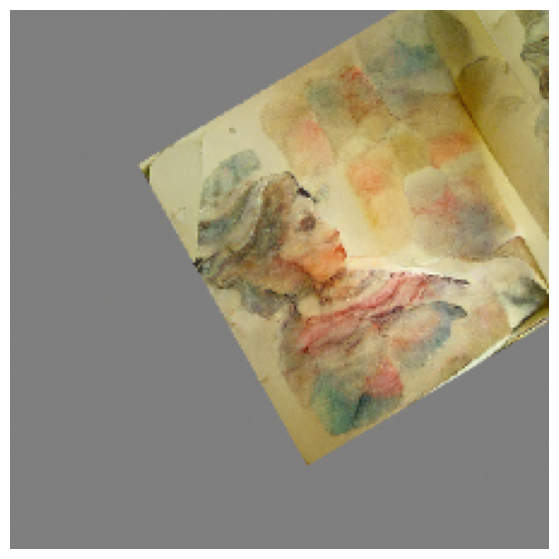

Generation


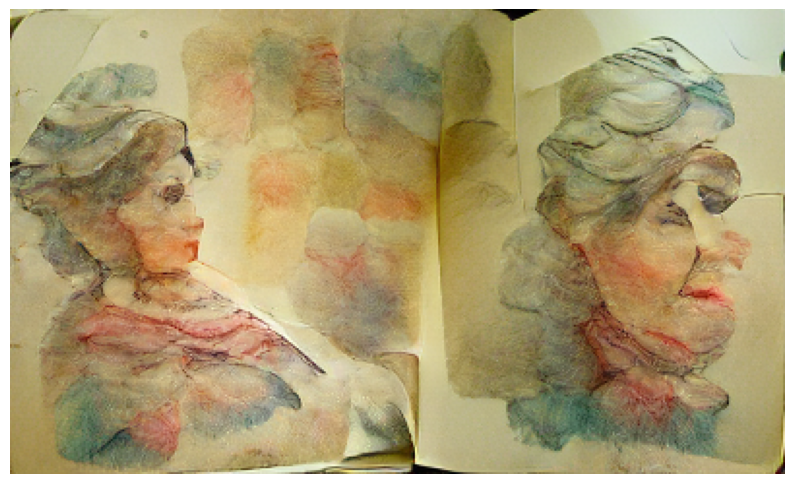

loss: -0.1876220703125 
iteration 399
Augmented crop example


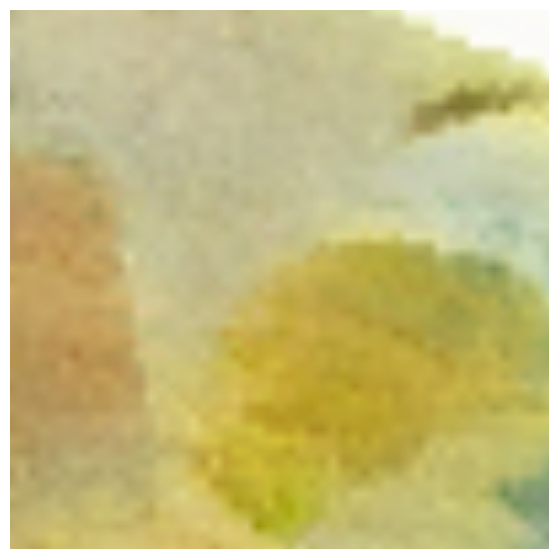

Generation


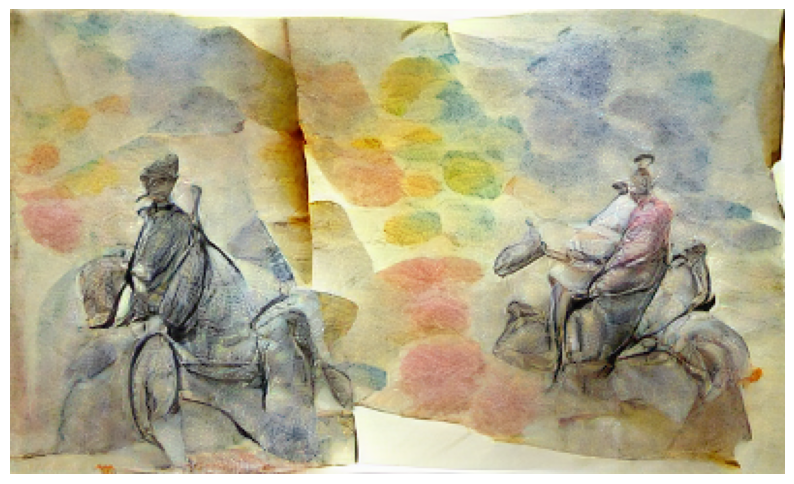

loss: -0.248779296875 
iteration 399


In [15]:
torch.cuda.empty_cache()
include = ['sketch of a lady', 'sketch of a man on a horse']
exclude = 'watermark, cropped, confusing, incoherent, cut, blurry'
extras = 'watercolor paper texture'

w1 = 1
w2 = 1

include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z = training_loop(Params, optimizer, show_crop=True)

In [16]:
print(len(res_img), len(res_z))
print(res_img[0].shape, res_z[0].shape)
print(res_z[0].max(), res_z[0].min())

2 2
torch.Size([3, 240, 400]) torch.Size([1, 256, 15, 25])
tensor(6.0507, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-5.8469, device='cuda:0', grad_fn=<MinBackward1>)


Augmented crop example


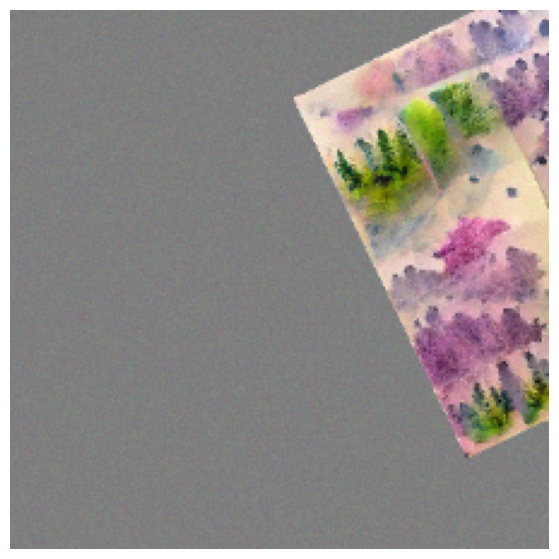

Generation


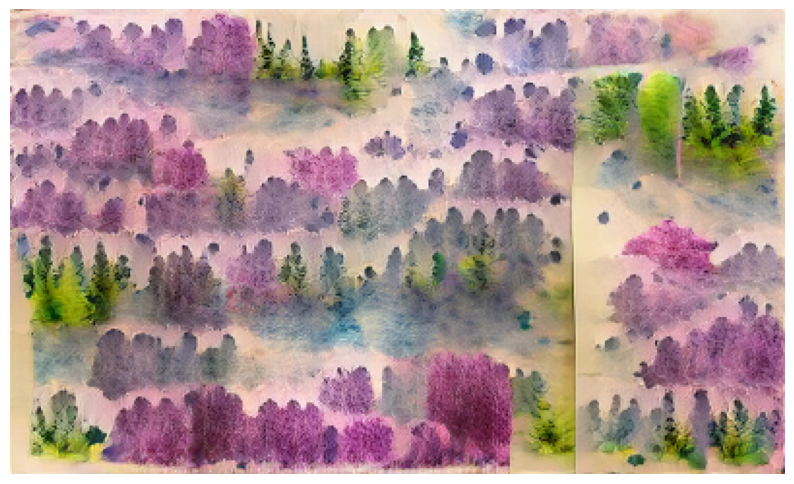

loss: -0.224853515625 
iteration 399
Augmented crop example


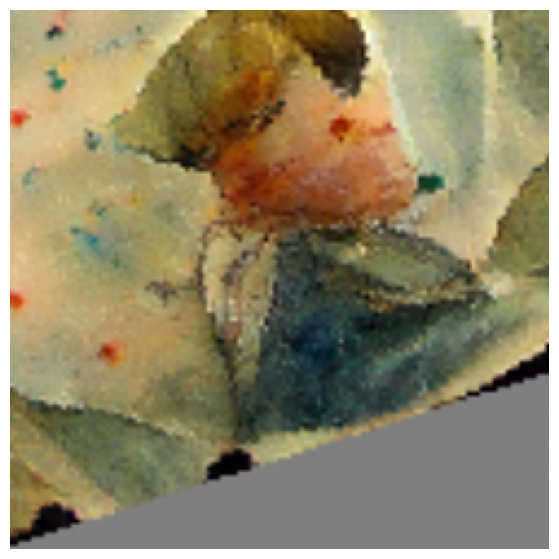

Generation


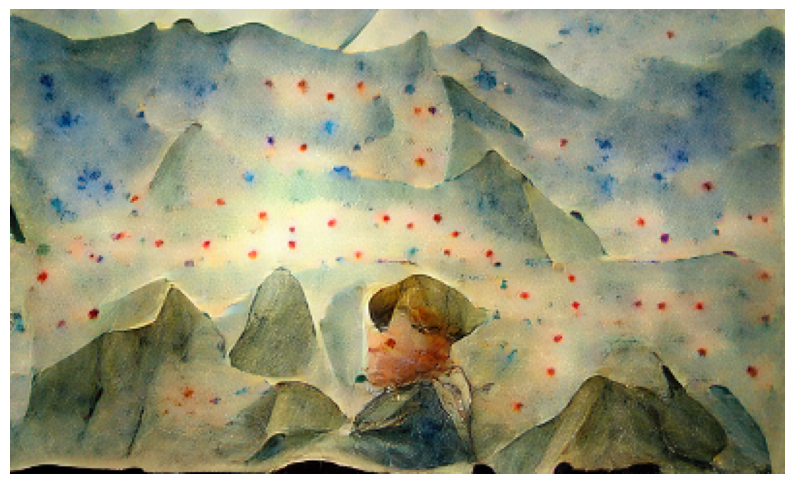

loss: -0.2469482421875 
iteration 399
Augmented crop example


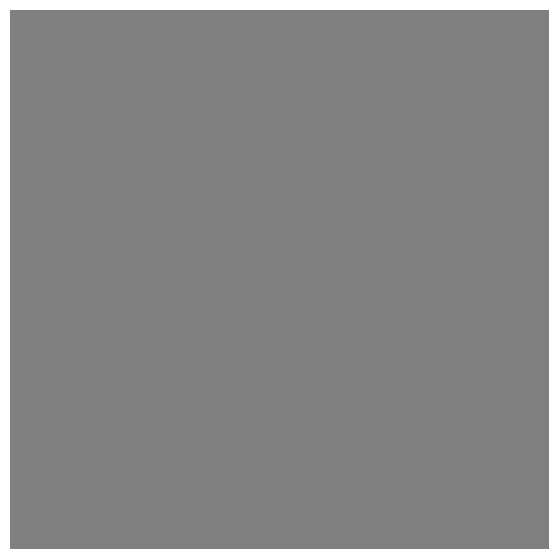

Generation


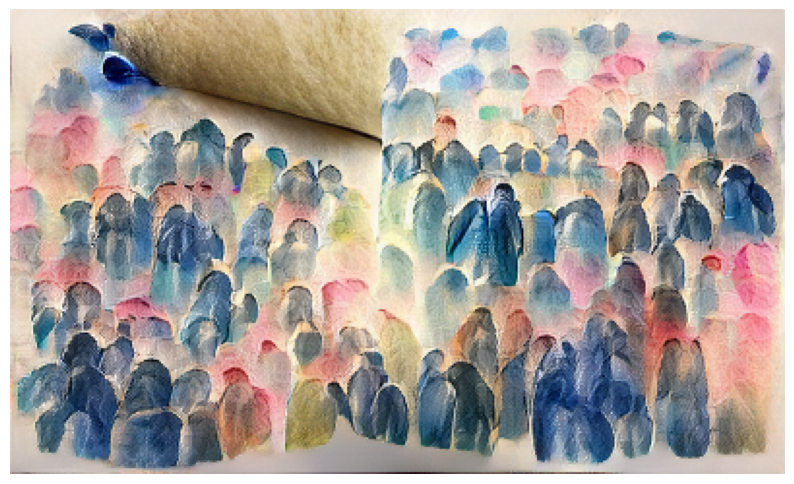

loss: -0.2056884765625 
iteration 399


In [17]:
torch.cuda.empty_cache()
include = ['a forest with purple trees', 'a boy at the top of a mountain, looking at the stars', 'one hundred people with blue jackets']
exclude = 'watermark, cropped, confusing, incoherent, cut, blurry'
extras = 'watercolor paper texture'

w1 = 1
w2 = 1

include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z = training_loop(Params, optimizer, show_crop=True)

In [18]:
def interpolate(res_z_list, duration_list):
    gen_img_list = []
    fps = 30

    for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)):
        num_steps = int(duration*fps)
        z1 = z
        z2 = res_z_list[(idx+1)%len(res_z_list)] # 1 x 256 x 14 x 25 (225/16, 400/16)

        for step in range(num_steps):
            alpha = math.sin(1.5*step/num_steps)**6 # the bigger the constant, the faster alpha increases or decreases
            z_new = alpha * z2 + (1 - alpha) * z1

            new_gen = norm_data(generator(z_new).cpu())[0] # 3x 224 x 400
            new_img = T.ToPILImage(mode='RGB')(new_gen)
            gen_img_list.append(new_img)

    return gen_img_list

durations = [5,5,5,5,5,5]
iterp_result_img_list = interpolate(res_z, durations)

In [19]:
###create a video
out_video_path = f"../video.mp4"
writer = imageio.get_writer(out_video_path, fps=30)

for pil_img in iterp_result_img_list:
    img = np.array(pil_img, dtype=np.uint8)
    writer.append_data(img)

writer.close()

In [20]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('../video.mp4','rb').read()
data="data:video/mp4;base64,"+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)